# Clasificador de flores

Bienvenidos. En este ejercicio haremos un clasificador para flores. Usaremos el siguiente dataset: http://www.robots.ox.ac.uk/~vgg/data/flowers/, que contiene 102 categorías y 8192 imágenes de flores de alta calidad. En un momento te diré cómo descargar el dataset ya editado por mi para hacerlo más fácil de manejar.

Al final lograremos llegar a 99.21% de accuracy, aún cuando tenemos 102 tipos de flores diferentes. Esto es muy impresionante, sobre todo considerando que en [este paper](https://www.robots.ox.ac.uk/~vgg/research/flowers_demo/docs/Chai11.pdf) reportan 81% de accuracy, y que en [este otro](http://www.cs.huji.ac.il/~daphna/IsraeliFlowers/flower_classification.html) reportan 93.8%! 

Es decir, lo haremos **7.7 veces mejor** que ese último!! (0.8% vs 6.2% de error)

Vamos a incluir las bibliotecas que usaremos, que son [fast.ai](https://www.fast.ai/) y [pytorch](https://pytorch.org).

In [1]:
import fastai.basics as fai
import fastai.vision as fv
from pathlib import Path

In [2]:
import torch
torch.cuda.is_available()

True

### ¿Cómo son nuestros datos?

Siempre antes de empezar a trabajar en algún problema, hay que entender bien qué problema queremos resolver. En este caso, simplemente queremos clasificar flores en base a sus imágenes.

Después, hay que entender los [datos](https://my.pcloud.com/publink/show?code=XZiwtw7Z15TY80dPm4b3KwmNcf1ChfphgM5y) de las flores. Pensemos que ya los descomprimimos y están en un carpeta llamada "flowers".

Esto creará una carpeta llamada "flowers" que contendrá dos subcarpetas: train y valid.

In [4]:
!ls flowers

models	train  valid


In [5]:
!ls flowers/train

alpine-sea-holly    fire-lily		       peruvian-lily
anthurium	    foxglove		       petunia
artichoke	    frangipani		       pincushion-flower
azalea		    fritillary		       pink-primrose
ball-moss	    garden-phlox	       pink-yellow-dahlia
balloon-flower	    gaura		       poinsettia
barbeton-daisy	    gazania		       primula
bearded-iris	    geranium		       prince-of-wales-feathers
bee-balm	    giant-white-arum-lily      purple-coneflower
bird-of-paradise    globe-flower	       red-ginger
bishop-of-llandaff  globe-thistle	       rose
blackberry-lily     grape-hyacinth	       ruby-lipped-cattleya
black-eyed-susan    great-masterwort	       siam-tulip
blanket-flower	    hard-leaved-pocket-orchid  silverbush
bolero-deep-blue    hibiscus		       snapdragon
bougainvillea	    hippeastrum		       spear-thistle
bromelia	    japanese-anemone	       spring-crocus
buttercup	    king-protea		       stemless-gentian
californian-poppy   lenten-rose		       sunflower
camellia	    lotus		       sweet

Ya entendimos cómo están las imágenes y su clasificación. (Nota: el archivo original que bajas de oxford no estaba bien acomodado así, estaba en un csv y así, medio feito, yo lo convertí.)

In [6]:
flowers = Path("flowers")

In [7]:
(flowers/"train").ls()

[PosixPath('flowers/train/petunia'),
 PosixPath('flowers/train/watercress'),
 PosixPath('flowers/train/wallflower'),
 PosixPath('flowers/train/garden-phlox'),
 PosixPath('flowers/train/gazania'),
 PosixPath('flowers/train/bougainvillea'),
 PosixPath('flowers/train/english-marigold'),
 PosixPath('flowers/train/ball-moss'),
 PosixPath('flowers/train/cautleya-spicata'),
 PosixPath('flowers/train/hibiscus'),
 PosixPath('flowers/train/hard-leaved-pocket-orchid'),
 PosixPath('flowers/train/poinsettia'),
 PosixPath('flowers/train/artichoke'),
 PosixPath('flowers/train/giant-white-arum-lily'),
 PosixPath('flowers/train/bishop-of-llandaff'),
 PosixPath('flowers/train/blackberry-lily'),
 PosixPath('flowers/train/pink-primrose'),
 PosixPath('flowers/train/pink-yellow-dahlia'),
 PosixPath('flowers/train/blanket-flower'),
 PosixPath('flowers/train/ruby-lipped-cattleya'),
 PosixPath('flowers/train/grape-hyacinth'),
 PosixPath('flowers/train/pincushion-flower'),
 PosixPath('flowers/train/marigold'),


## Abriendo los datos en fastai

Dado que nuestros datos están bien acomodados en folders, vamos a crear un "ImageDataBunch" a partir del folder.

Usaremos "data augmentation" (más sobre esto después), estableciendo transformadas.

In [9]:
tfms = fv.get_transforms(flip_vert=True, max_rotate=360, max_lighting=0.3,max_zoom=1.2) #tfms = transforms

**Nota:** bs = batch size. Es decir, cuántas imágenes pasa al mismo tiempo a la red neuronal. Mi tarjeta de video tiene 11GB de memoria, por es puedo poner un número relativamente grande. Si obtienes "CUDA error: out of memory", disminuye la batch size!

Podríamos también cargar los datos "a mano", como se muestra en las siguientes celdas. Para más información, ver el [datablock-api](https://docs.fast.ai/data_block.html)

In [10]:
def load_data(folder, img_size, batch_size):  
    data = (fv.ImageList
            .from_folder(folder)
            .split_by_folder()
            .label_from_folder()
            .transform(tfms,size=img_size)
            .databunch(bs=batch_size))
    return data

In [11]:
data = load_data(flowers, img_size=256, batch_size=64)

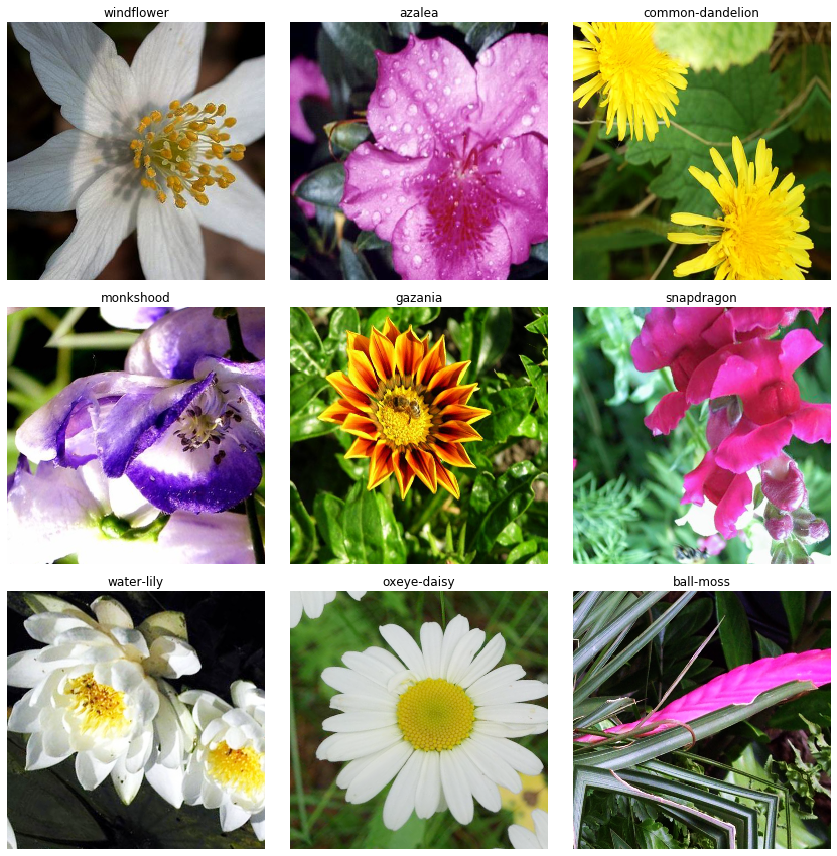

In [12]:
data.show_batch(rows=3)

## Entrenamiento

Ahora crearemos un objeto de tipo "Learner" (más sobre esto después), con arquitectura de "resnet18". Qué es esto? No te preocupes!

In [13]:
learner = fv.cnn_learner(data, fv.models.resnet18, metrics=fai.accuracy, wd=0.1)

### Entrenamos *sólo de las últimas capas*

Vamos a usar la función "fit_one_cycle", que es una manera muy rápida de entrenar (discutiremos por qué después). wd significa "weight decay" y es para hacer "regularización l2" (veremos qué significa después)

In [14]:
learner.fit_one_cycle(4)

RuntimeError: cuda runtime error (11) : invalid argument at /pytorch/aten/src/THC/THCGeneral.cpp:383

No sabemos qué taza de aprendizaje usar, y de hecho hemos estado usando la que trae por defecto (0.003). ¿Qué learning rate usamos? Pues vamos a averiguar!

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


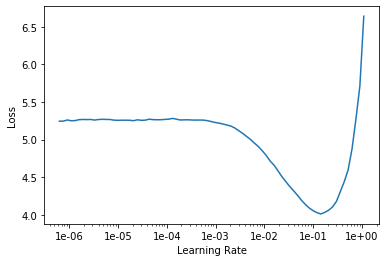

In [16]:
learner.lr_find(); learner.recorder.plot()

In [17]:
learner.fit_one_cycle(1, max_lr = 2e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


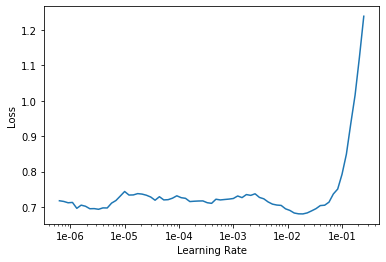

In [18]:
learner.lr_find(); learner.recorder.plot()

In [19]:
learner.fit_one_cycle(3,4e-3)

In [ ]:
learner.save('stage1')

In [ ]:
learner.load("stage1");

### Taza de aprendizaje cíclica 

Como funciona el método fit_one_cycle? Se ha encontrado, experimentalmente, que ir modificando la taza de aprendizaje (learning rate) en "ciclos" mejora mucho el resultado final de la red. Después entenderemos la razón, pero tiene que ver con que son mejores los "mínimos gordos" que los "mínimos flacos". [Paper](https://arxiv.org/abs/1506.01186)

In [ ]:
learner.recorder.plot_losses()

In [ ]:
learner.recorder.plot_lr(show_moms=True)

In [ ]:
learner.summary()

### Entrenamiento de TODAS las capas

En realidad **no hemos estado entrenando a toda la red neuronal!!** Sólo entrenamos las últimas dos capas, y las demás estaban **pre-entrenadas en imagenet**. Por defecto, si pides una arquitectura pre-hecha, vienen "congeladas" las primeras capas. Vamos a entrenar con cuidado toda la red.

In [20]:
learner.unfreeze() # ahora hay que tener cuidado!

In [ ]:
learner.lr_find(); learner.recorder.plot()

In [ ]:
learner.summary()

Vamos a entrenar toda la red, pero vamos a modificar las primeras capas **menos que las últimas**. Para entender por qué, veamos este paper: [Visualizing and Understading ...](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf)

In [21]:
learner.fit_one_cycle(5, max_lr=slice(2e-5,1e-3))

In [ ]:
learner.save('stage2')

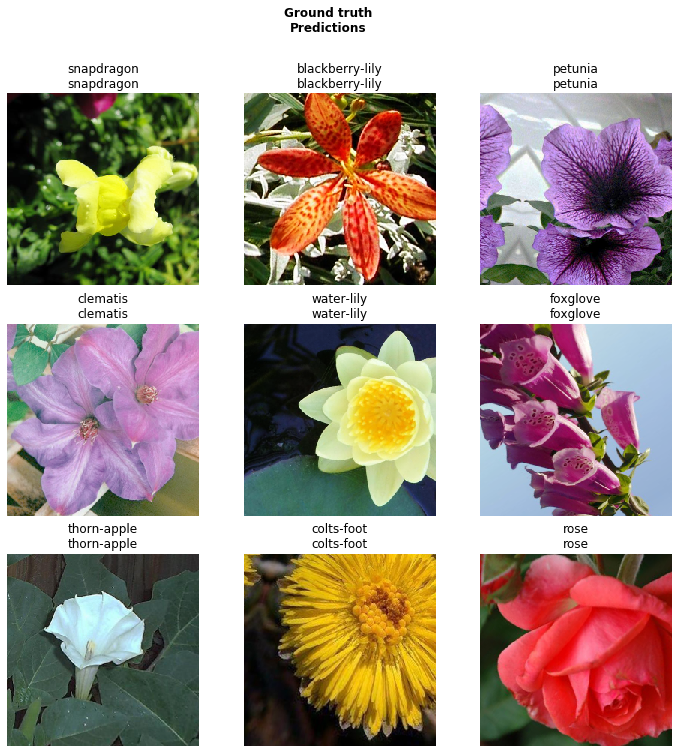

In [23]:
learner.show_results(ds_type=fai.DatasetType.Train, rows=3) # Podemos cambiar Valid por Train

# Interpretando los resultados

#### Test Time Augmentation
Así como hicimos data augmentation al entrenar, ¿por qué no hacerlo también al inferir?

In [24]:
fai.accuracy(*learner.TTA())

tensor(0.9783)

Vamos a revisar los resultados que tenemos

In [25]:
interp = learner.interpret()

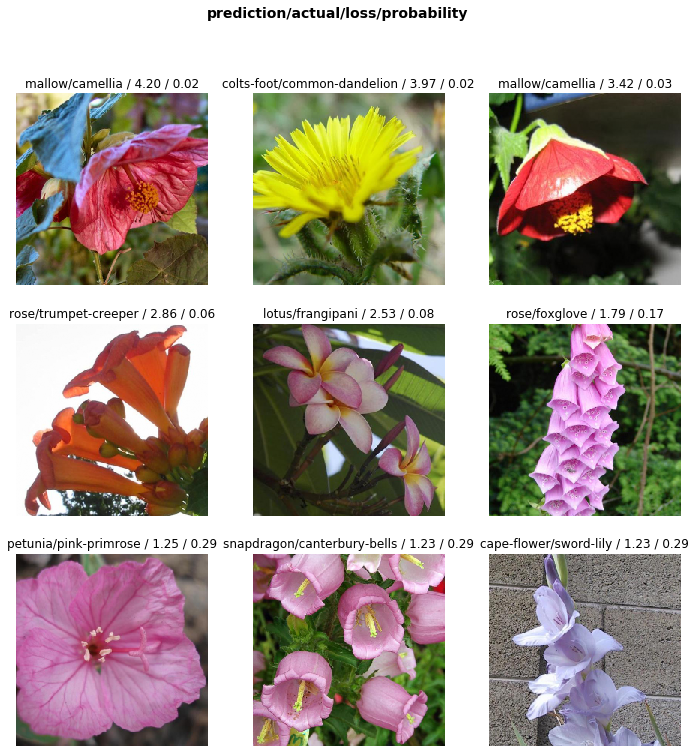

In [29]:
interp.plot_top_losses(9,heatmap=False)

Las dos que predecimos mallow pero deberíamos predecir camellia... están de hecho mal clasificadas en el validation set!

Esto es algo muy común, los datasets no son perfectos. Y hacer este tipo de cosas nos da herramientas para encontrar estos errores.

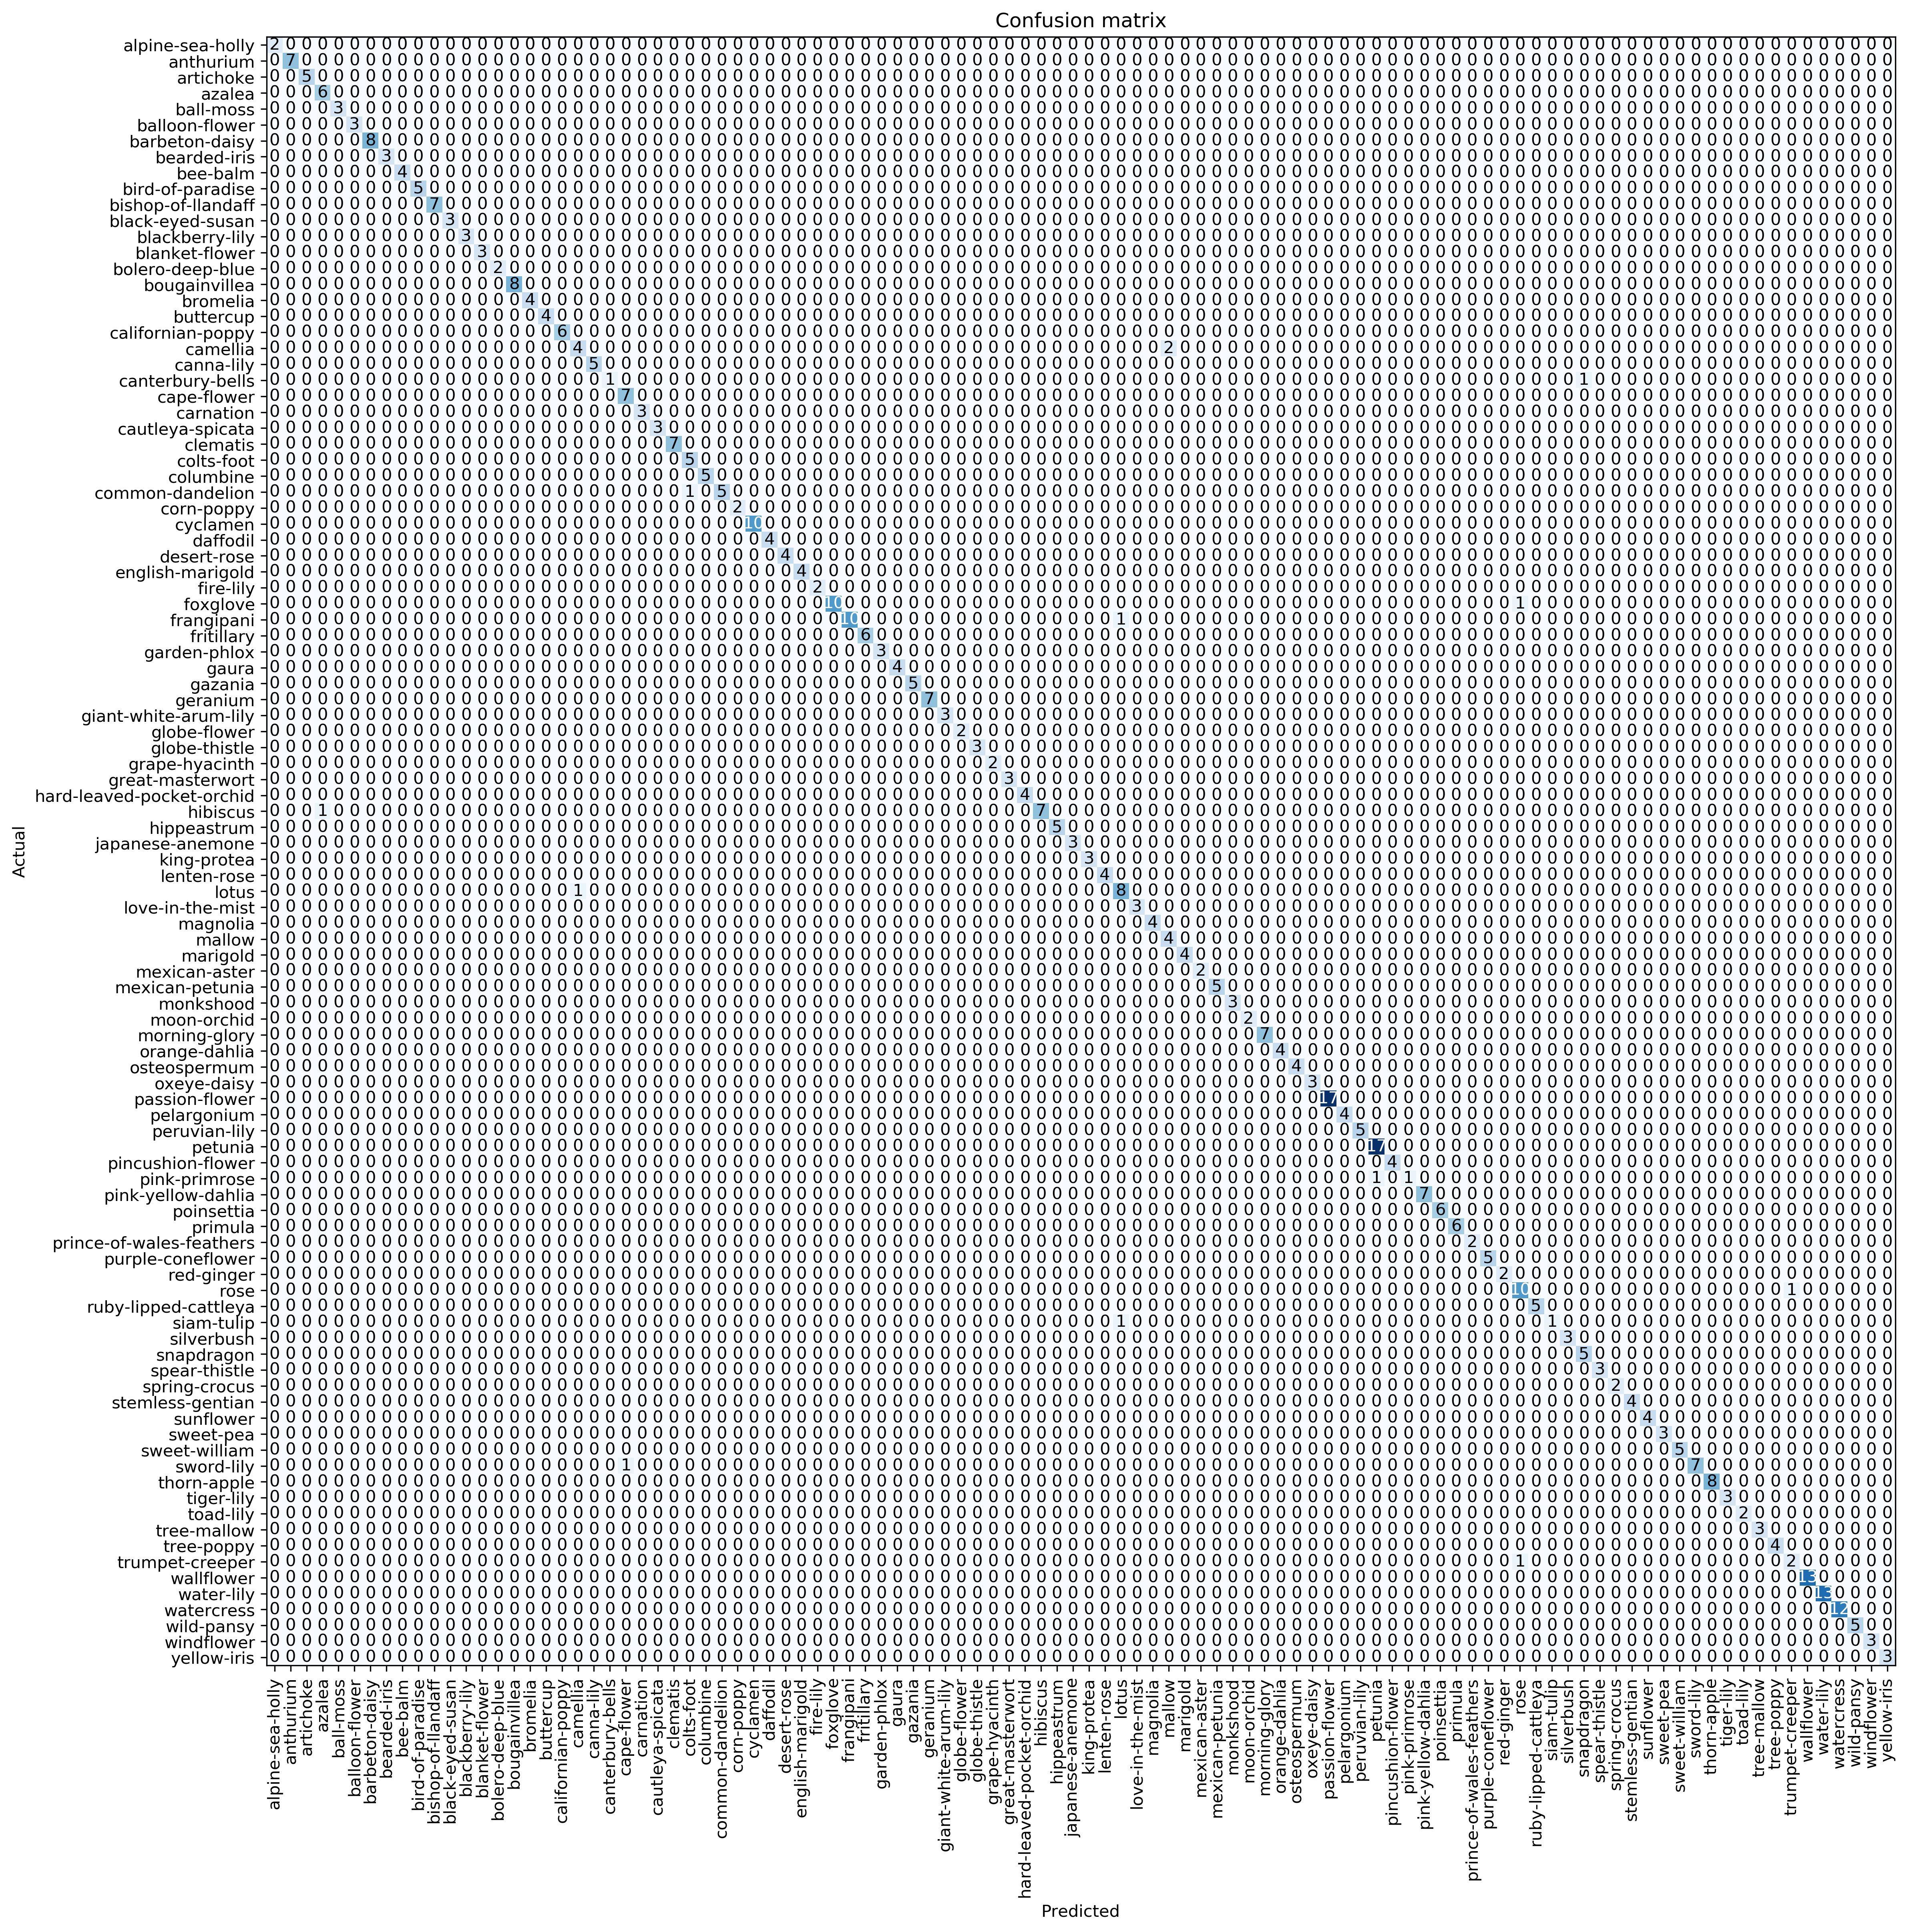

In [30]:
interp.plot_confusion_matrix(figsize=(16,16), dpi=300)

In [34]:
interp.most_confused(1)

[('camellia', 'mallow', 2),
 ('canterbury-bells', 'snapdragon', 1),
 ('common-dandelion', 'colts-foot', 1),
 ('foxglove', 'rose', 1),
 ('frangipani', 'lotus', 1),
 ('hibiscus', 'azalea', 1),
 ('lotus', 'camellia', 1),
 ('pink-primrose', 'petunia', 1),
 ('rose', 'trumpet-creeper', 1),
 ('siam-tulip', 'lotus', 1),
 ('sword-lily', 'cape-flower', 1),
 ('trumpet-creeper', 'rose', 1)]